<img src="http://static1.squarespace.com/static/55d78486e4b038548bc9f33e/t/55ec5931e4b0518639da93c6/1448895140273/?format=1500w"/>

# <center> Getting Started With The FARS Dataset </center>

## Introduction

In this notebook we will introduce the FARS dataset and create a simple prediction model.

## The Data

You can find the data <a href=https://inclass.kaggle.com/c/mdst-fars>here</a>.

The National Highway Traffic Safety Administration (NHTSA) regulates motor vehicle safety in the United States.  Part of this effort is collecting data about fatal car accidents.  This data collection is called the Fatality Awareness Reporting System.  In this challenge, we will be predicting whether a fatal accident involved drunk driving or not.

Let's explore what sorts of data we have available.  For a full accounting, see the data definition spreadsheet included with the data.  

### The Accident Table

This table contains general data for each fatal accident.  This data contains a unique identifier, 'ID' and things like geographical location, time, and weather.

### The Person Table

This table contains data about the people involved in the accident.  This includes demographic data and time of death.  The 'ID' columns matches people to accidents.

### The Vehicle Table

Information about the vehicles involved in the accident, such as the make, model, and year of the vehicle.  The 'ID' column matches vehicles to accidents.

## Working With The Data

The following code will gives an introduction to working with the FARS data set in Python.

In [12]:
# Import libraries and data.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

stringify = lambda x: str(x)
converter_dict = {
    'STATE': stringify,
    'COUNTY': stringify,
    'CITY': stringify,
    'DAY': stringify, # yah? doesn't seem numeric
    'MONTH': stringify,
    'DAY_WEEK': stringify,
    'HOUR': stringify,
    'MINUTE': stringify,
    'NHS': stringify, # blank = -1
    'ROAD_FNC': stringify, # blank = -1
    'ROUTE': stringify, # blank = -1
    # MILEPT : [-40, 99999] ? no info in defs
    'SP_JUR': stringify, # blank = -1
    'HARM_EV': stringify, # unk = 99, no blank
    'MAN_COLL': stringify, # blank = -1, unk=99
    'REL_ROAD': stringify, # blank = -1, unk=99
    'LGT_COND': stringify, # blank = -1, unk=9
    'WEATHER': stringify, # blank = -1, unk=9
    'SCH_BUS': stringify, # blank = -1
#     'RAIL' - remove
#     'TWAY_ID', - remove
#     'YEAR' - remove
    'NOT_HOUR': stringify,
    """
    strange ones:
    99	Unknown
    24	12:00pm
    -1	Blank
    88	Not Applicable
    """
    'NOT_MIN': stringify,
    """
    -1	Blank
    99	Unknown
    88	Not Applicable
    """
    'ARR_HOUR': stringify, # same format as NOT_HOUR
    'ARR_MIN': stringify, # same format as NOT_MIN
    'HOSP_HR': stringify, # same format as NOT_HOUR
    'HOSP_MN': stringify, # same format as NOT_MIN
    'CF1': stringify, # blank = -1, unk=99
    'CF2': stringify, # same as CF1
    'CF3': stringify, # same as CF1
#     'FATALS' - numeric
}

acc_df = pd.read_csv('./train/accident_train.csv', converters=converter_dict)
test_df = pd.read_csv('./test/accident_test.csv')
# per_df = pd.read_csv('./train/person_train.csv')
# veh_df = pd.read_csv('./train/vehicle_train.csv')

In [13]:
# Create a train-test split on just the accident data for model testing.
from sklearn.cross_validation import train_test_split

acc_df.fillna(-1, inplace=True)
Ydata = acc_df['DRUNK_DR'].values
extra_drop = [
    'MINUTE',
    'NOT_MIN',
    'ARR_MIN',
    'HOSP_MN',
    'NHS',
    'LATITUDE',
    'LONGITUD',
    'DAY',
    'COUNTY',
    'CITY',
    'ARR_HOUR',
    'HOSP_HR',
    'STATE',
    'MONTH',
    'ROAD_FNC',
    'ROUTE',
    'SP_JUR',
    'MILEPT', # big one in overfit
    'CF1',
    'CF2',
    'CF3',
    # ^rf still at 90 on tr and 75 on validation
#     'HARM_EV',
]
categorical_drop = [
    'DAY_WEEK',
    'HOUR',
    'REL_ROAD',
    'LGT_COND',
    'WEATHER',
    'SCH_BUS',
    'STATE',
    'NOT_HOUR',
    'HARM_EV',
]

# change categoricals to 1-hot? and then drop the old columns
pd.concat(
    [
        acc_df,
        pd.get_dummies(acc_df['DAY_WEEK'],prefix = 'DAY_WEEK_').astype(np.int8),
        pd.get_dummies(acc_df['HOUR'],prefix = 'HOUR_').astype(np.int8),
        pd.get_dummies(acc_df['REL_ROAD'],prefix = 'REL_ROAD_').astype(np.int8),
        pd.get_dummies(acc_df['LGT_COND'],prefix = 'LGT_COND_').astype(np.int8),
        pd.get_dummies(acc_df['WEATHER'],prefix = 'WEATHER_').astype(np.int8),
        pd.get_dummies(acc_df['SCH_BUS'],prefix = 'SCH_BUS_').astype(np.int8),
        pd.get_dummies(acc_df['STATE'],prefix = 'STATE_').astype(np.int8),
        pd.get_dummies(acc_df['NOT_HOUR'],prefix = 'NOT_HOUR_').astype(np.int8),
        pd.get_dummies(acc_df['HARM_EV'],prefix = 'HARM_EV_').astype(np.int8),
    ],
    axis=1)
acc_df.sort(axis=1, inplace=True)
acc_df.drop(['DRUNK_DR', 'RAIL', 'ID', 'TWAY_ID', 'YEAR'] +
            extra_drop + categorical_drop,
            axis=1,
            inplace=True)
Xdata = acc_df.values

Xtr, Xte, Ytr, Yte = train_test_split(Xdata, Ydata)

In [14]:
# Let's train a simple regression model using sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# acc_df[acc_df.MILEPT < 99993]['MILEPT'].describe()
acc_df.head()

,FATALS,MAN_COLL,PEDS,PERSONS,VE_FORMS
0,1,0,0,1,1
1,1,0,0,1,1
2,1,0,0,1,1
3,1,0,0,1,1
4,1,3,0,3,2


In [15]:
# Fit the models on the our train-test-split
lr = LogisticRegression()
rf = RandomForestClassifier()

lr.fit(Xtr, Ytr)
rf.fit(Xtr, Ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
lr.score(Xtr, Ytr)

0.7083254129788723

In [17]:
rf.score(Xtr, Ytr)

0.70972094079902082

In [18]:
# Make predictions on our test set from train-test-split
yhat1 = lr.predict_proba(Xte)
yhat2 = rf.predict_proba(Xte)

In [19]:
# 

from sklearn.metrics import roc_auc_score as auc

auc1 = auc(Yte.astype(int), yhat1[:,1])
auc2 = auc(Yte.astype(int), yhat2[:,1])

In [20]:
auc1, auc2

(0.67084154847938415, 0.67747476409419061)

In [21]:
# Given a prediction, create a Kaggle submission file
test_df.fillna(-1, inplace=True)
# change categoricals to 1-hot? and then drop the old columns
pd.concat(
    [
        test_df,
        pd.get_dummies(test_df['DAY_WEEK'],prefix = 'DAY_WEEK_').astype(np.int8),
        pd.get_dummies(test_df['HOUR'],prefix = 'HOUR_').astype(np.int8),
        pd.get_dummies(test_df['REL_ROAD'],prefix = 'REL_ROAD_').astype(np.int8),
        pd.get_dummies(test_df['LGT_COND'],prefix = 'LGT_COND_').astype(np.int8),
        pd.get_dummies(test_df['WEATHER'],prefix = 'WEATHER_').astype(np.int8),
        pd.get_dummies(test_df['SCH_BUS'],prefix = 'SCH_BUS_').astype(np.int8),
        pd.get_dummies(test_df['STATE'],prefix = 'STATE_').astype(np.int8),
        pd.get_dummies(test_df['NOT_HOUR'],prefix = 'NOT_HOUR_').astype(np.int8),
        pd.get_dummies(test_df['HARM_EV'],prefix = 'HARM_EV_').astype(np.int8),
    ],
    axis=1)
test_df.sort(axis=1, inplace=True)
# test_df.reindex_axis(sorted(acc_df.columns), axis=1)
# test_df.head()

Xsubmit = test_df.drop(['RAIL', 'ID', 'TWAY_ID'] +
                       extra_drop + categorical_drop,
                       axis=1).values
Yhat = rf.predict_proba(Xsubmit)
# Yhat

submit = pd.DataFrame(data={'ID': test_df['ID'], 'DRUNK_DR': Yhat[:,1]})
submit.to_csv('fars_submit.csv', index = False)

In [48]:
# Let's explore the data a little bit.
year_group = acc_df.groupby('YEAR')

In [21]:
years = list(year_group.groups.keys())
fatals = np.zeros(len(years))
for i, year in enumerate(years):
    fatals[i] = acc_df.ix[year_group.groups[year]]['FATALS'].sum()

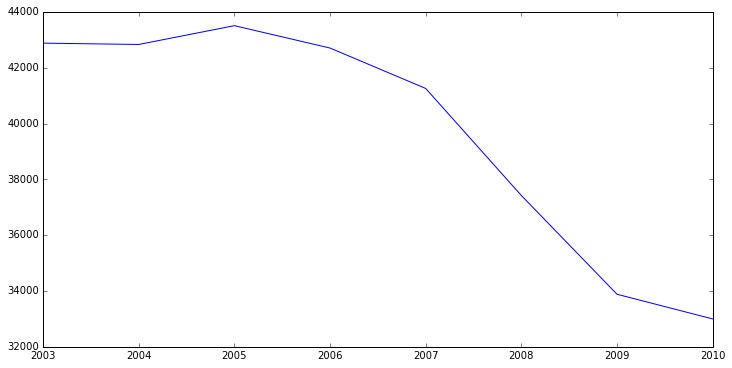

In [47]:
fig = plt.figure()
fig.set_size_inches(12,6)

ax = fig.add_subplot(111)
ax.plot(years, fatals)
labels = ax.set_xticklabels([str(year) for year in years])

In [50]:
state_group = acc_df.groupby('STATE')
states = list(state_group.groups.keys())
fatals = np.zeros(len(states))
for i, state in enumerate(states):
    fatals[i] = acc_df.ix[state_group.groups[state]]['FATALS'].sum()

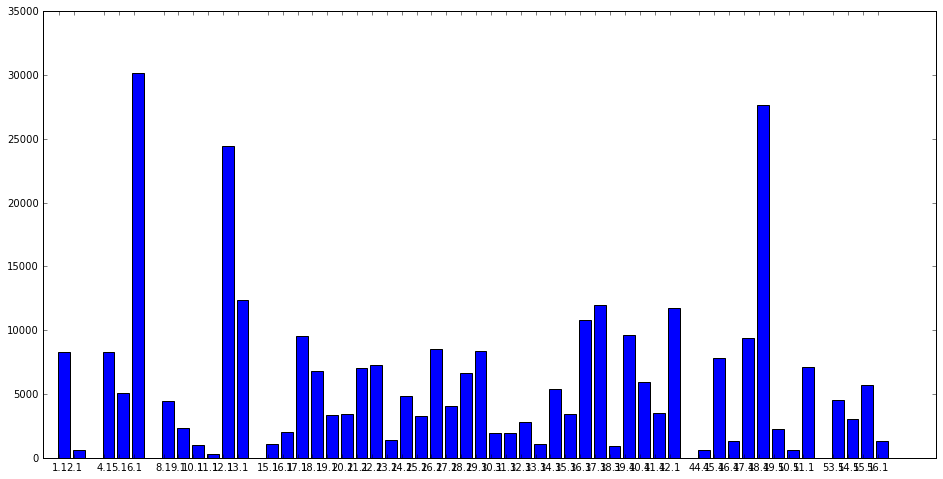

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
width = 0.1

states = 
["Alabama ","Alaska ","Arizona ","Arkansas ",
"California ",
"Colorado ",
"Connecticut ", 
"Delaware ",
"Florida ",
"Georgia ",
"Hawaii ",
"Idaho ",
"Illinois ",
"Indiana ",
"Iowa ",
"Kansas ",
"Kentucky ",
"Louisiana ",
"Maine ",
"Maryland ",
"Massachusetts ",
"Michigan ",
"Minnesota ",
"Mississippi", 
"Missouri ",
"Montana ",
"Nebraska ",
"Nevada ",
"New Hampshire ", 
"New Jersey ",
"New Mexico ",
"New York ",
"North Carolina ","North Dakota ","Ohio ","Oklahoma ","Oregon ","Pennsylvania ","Rhode Island ","South Carolina ","South Dakota ", "Tennessee ","Texas ","Utah ","Vermont ","Virginia ","Washington ","West Virginia ", "Wisconsin ", "Wyoming "]


ax.bar(states, fatals)
ticks = ax.set_xticks(np.array(states) + width)
ax.set_xticklabels()
# labels = ax.set_xticklabels([str(year) for year in years]")

In [57]:
fatals

array([  8302.,    610.,   8315.,   5078.,  30156.,   4467.,   2323.,
         1012.,    326.,  24485.,  12334.,   1043.,   2014.,   9555.,
         6785.,   3339.,   3441.,   7030.,   7271.,   1416.,   4809.,
         3293.,   8538.,   4072.,   6622.,   8366.,   1922.,   1969.,
         2818.,   1096.,   5428.,   3421.,  10805.,  11964.,    899.,
         9667.,   5934.,   3498.,  11747.,    639.,   7855.,   1315.,
         9358.,  27656.,   2246.,    611.,   7124.,   4493.,   3070.,
         5673.,   1292.])